<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Clustering based Course Recommender System**


Estimated time needed: **90** minutes


Previously, we have generated user profile vectors based on course ratings and genres. 

A user profile vector may look like a row vector in the following matrix, for example, we can see the Database column for user2 has a value 1 which means user2 is very interesting in courses related to the databases. With the user profile vectors generated, we can also easily compute the similarity among users based on their shared interests.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_3/images/userprofiles.png)


Furthermore, we could perform clustering algorithms such as K-means or DBSCAN to group users with similar learning interests. For example, in the below user clusters, we have user clusters whom have learned courses related to machine learning, cloud computing, databases, and web development, etc.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_3/images/userprofiles_clustering.png)


For each user group, we can come up with a list of popular courses. For example, for the machine learning user cluster/learning group, we can count the most frequently enrolled courses, which are very likely to be the most popular and good machine learning courses because they are enrolled by many users who are interested in machine learning. 

If we know a user belongs to the machine learning group, we may recommend the most enrolled courses to them and it is very likely the user will be interested in them.


Next in this lab, you will be implementing some clustering-based recommender system algorithms.


## Objectives


After completing this lab you will be able to:


* Perform k-means clustering on the original user profile feature vectors
* Apply PCA (Principle Component Analysis ) on user profile feature vectors to reduce dimensions
* Perform k-means clustering on the PCA transformed main components
* Generate course recommendations based on other group members' enrollment history


----


## Prepare and setup lab environment


First install and import required libraries:


In [1]:
%pip install scikit-learn
%pip install seaborn
%pip install pandas
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

In [3]:
# also set a random state
rs = 123

### Load the user profile dataset


Let's first load the original user profile feature vectors:


In [4]:
# Importing the pandas library, which is commonly used for data manipulation and analysis
import pandas as pd

# Defining the URL of the CSV file containing user profiles
user_profile_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_profile.csv"

# Using pandas' read_csv function to read the CSV file from the specified URL into a DataFrame
user_profile_df = pd.read_csv(user_profile_url)

# Displaying the first few rows of the DataFrame to inspect its contents
user_profile_df.head()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,2,52.0,14.0,6.0,43.0,3.0,33.0,0.0,29.0,41.0,2.0,18.0,34.0,9.0,6.0
1,4,40.0,2.0,4.0,28.0,0.0,14.0,0.0,20.0,24.0,0.0,6.0,6.0,0.0,2.0
2,5,24.0,8.0,18.0,24.0,0.0,30.0,0.0,22.0,14.0,2.0,14.0,26.0,4.0,6.0
3,7,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,8,6.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0


In [5]:
user_profile_df.shape

(33901, 15)

we can then list the feature names, they are the user interested topics (course genres):


In [6]:
feature_names = list(user_profile_df.columns[1:])
feature_names

['Database',
 'Python',
 'CloudComputing',
 'DataAnalysis',
 'Containers',
 'MachineLearning',
 'ComputerVision',
 'DataScience',
 'BigData',
 'Chatbot',
 'R',
 'BackendDev',
 'FrontendDev',
 'Blockchain']

As we can see from the user profile dataset, we have about 33K unique users with interests in areas like ``Database``, ``Python``, ``CloudComputing``, etc. Then, let's check the  summary statistics for each feature.


In [7]:
user_profile_df.describe()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
count,3.390100e+04,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000
mean,1.064064e+06,5.518569,3.493791,2.307100,3.624701,0.998938,3.048022,0.001770,5.087343,4.750450,0.462995,1.017433,2.269461,0.315802,0.986844
std,4.972578e+05,7.611941,4.227254,3.841858,4.760135,2.351764,4.624004,0.072846,5.230697,7.216228,1.055186,2.342532,4.310752,1.363462,1.950585
min,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.813480e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.043907e+06,3.000000,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.451159e+06,9.000000,6.000000,3.000000,6.000000,0.000000,3.000000,0.000000,9.000000,6.000000,0.000000,0.000000,3.000000,0.000000,2.000000
max,2.103039e+06,63.000000,18.000000,38.000000,48.000000,15.000000,39.000000,3.000000,32.000000,54.000000,6.000000,18.000000,54.000000,15.000000,12.000000


The original user profile feature vector is not normalized, which may cause issues when we perform clustering and Principal component analysis (PCA), therefor we standardize the data.


In [8]:
# Use StandardScaler to make each feature with mean 0, standard deviation 1
# Instantiating a StandardScaler object
scaler = StandardScaler()

# Standardizing the selected features (feature_names) in the user_profile_df DataFrame
user_profile_df[feature_names] = scaler.fit_transform(user_profile_df[feature_names])

# Printing the mean and standard deviation of the standardized features
print("mean {} and standard deviation{} ".format(user_profile_df[feature_names].mean(), user_profile_df[feature_names].std()))

mean Database          -2.682796e-17
Python            -5.365592e-17
CloudComputing    -1.341398e-17
DataAnalysis      -7.545364e-17
Containers         1.341398e-17
MachineLearning    3.353495e-17
ComputerVision    -7.545364e-18
DataScience       -2.012097e-17
BigData            6.706990e-17
Chatbot           -6.036291e-17
R                  5.700942e-17
BackendDev         2.012097e-17
FrontendDev        2.012097e-17
Blockchain        -6.706990e-17
dtype: float64 and standard deviationDatabase           1.000015
Python             1.000015
CloudComputing     1.000015
DataAnalysis       1.000015
Containers         1.000015
MachineLearning    1.000015
ComputerVision     1.000015
DataScience        1.000015
BigData            1.000015
Chatbot            1.000015
R                  1.000015
BackendDev         1.000015
FrontendDev        1.000015
Blockchain         1.000015
dtype: float64 


In [9]:
user_profile_df.describe()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
count,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04
mean,1.064064e+06,-2.682796e-17,-5.365592e-17,-1.341398e-17,-7.545364e-17,1.341398e-17,3.353495e-17,-7.545364e-18,-2.012097e-17,6.706990e-17,-6.036291e-17,5.700942e-17,2.012097e-17,2.012097e-17,-6.706990e-17
std,4.972578e+05,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00
min,2.000000e+00,-7.249991e-01,-8.265040e-01,-6.005256e-01,-7.614816e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-9.726080e-01,-6.583107e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
25%,6.813480e+05,-7.249991e-01,-8.265040e-01,-6.005256e-01,-7.614816e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-9.726080e-01,-6.583107e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
50%,1.043907e+06,-3.308757e-01,-1.168130e-01,-6.005256e-01,-1.312380e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-3.990622e-01,-3.811535e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
75%,1.451159e+06,4.573712e-01,5.928781e-01,1.803581e-01,4.990056e-01,-4.247674e-01,-1.038556e-02,-2.429612e-02,7.480294e-01,1.731609e-01,-4.387873e-01,-4.343370e-01,1.694715e-01,-2.316212e-01,5.194189e-01
max,2.103039e+06,7.551593e+00,3.431642e+00,9.290667e+00,9.322416e+00,5.953517e+00,7.775190e+00,4.115884e+01,5.145214e+00,6.824934e+00,5.247500e+00,7.249771e+00,1.200053e+01,1.076995e+01,5.646161e+00


The normalized user profile features are: 


In [10]:
features = user_profile_df.loc[:, user_profile_df.columns != 'user']
features

,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,6.106474,2.485388,0.961242,8.272010,0.850889,6.477594,-0.024296,4.571668,5.023412,1.456642,7.249771,7.360899,6.369323,2.570116
1,4.529980,-0.353377,0.440653,5.120792,-0.424767,2.368540,-0.024296,2.851031,2.667576,-0.438787,2.127032,0.865416,-0.231621,0.519419
2,2.427988,1.066006,4.084776,4.280467,-0.424767,5.828796,-0.024296,3.233395,1.281790,1.456642,5.542191,5.505047,2.702132,2.570116
3,-0.462250,-0.826504,-0.600526,-0.341319,-0.424767,-0.659184,-0.024296,-0.972608,-0.381153,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930
4,0.063248,-0.826504,-0.600526,0.078843,-0.424767,-0.659184,-0.024296,-0.972608,0.173161,-0.438787,0.419453,-0.526473,-0.231621,-0.505930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33896,-0.330876,-0.116813,0.180358,0.499006,-0.424767,-0.659184,-0.024296,0.174484,-0.658311,-0.438787,2.127032,0.865416,-0.231621,1.032093
33897,-0.724999,-0.826504,-0.079936,-0.761482,-0.424767,-0.659184,-0.024296,-0.972608,-0.658311,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930
33898,-0.330876,0.592878,0.961242,-0.761482,-0.424767,2.368540,-0.024296,0.748029,-0.658311,-0.438787,0.846348,-0.526473,-0.231621,-0.505930
33899,-0.724999,-0.826504,-0.600526,-0.761482,-0.424767,-0.226652,-0.024296,-0.972608,-0.658311,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930


we can also save the user ids for later recommendation tasks:


In [11]:
user_ids = user_profile_df.loc[:, user_profile_df.columns == 'user']
user_ids

,user
0,2
1,4
2,5
3,7
4,8
...,...
33896,2102054
33897,2102356
33898,2102680
33899,2102983


### TASK: Perform K-means clustering algorithm on the user profile feature vectors


With the user profile dataset ready, you need to use the `KMeans` class provided by scikit-learn library to perform clustering on the user profile feature vectors. 


For `KMeans` algorithm, one important hyperparameter is the number of clusters `n_cluster`, and a good way to find the optimized `n_cluster` is using to grid search a list of candidates and find the one with the best or optimized clustering evaluation metrics such as minimal `sum of squared distance`:


_TODO: grid search the optimized n_cluster for KMeans() model_


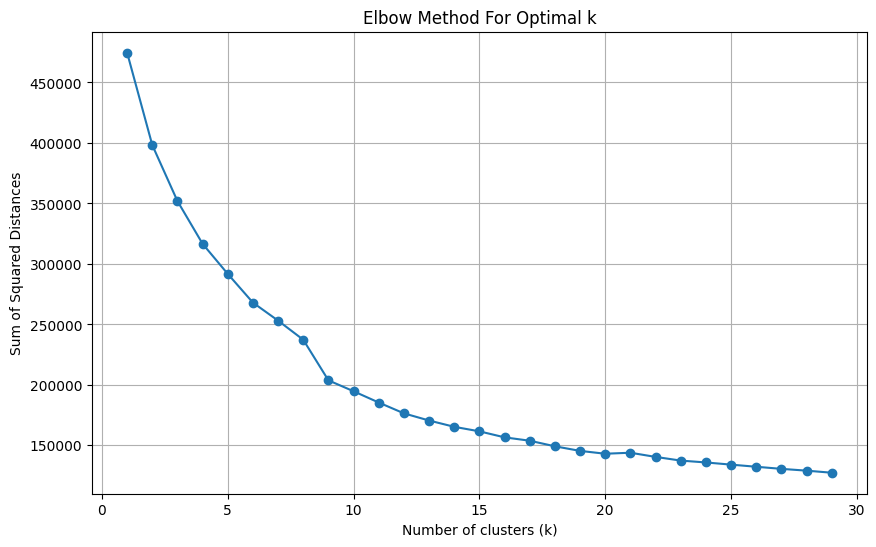

In [12]:
# WRITE YOUR CODE HERE

# Find an optimized number of neighors k from a candidate list such as list_k = list(range(1, 30))

# Define a range of candidate values for the number of clusters
list_k = list(range(1, 30))

# Initialize an empty list to store the sum of squared distances for each model
sum_of_squared_distances = []

# Perform K-means clustering for each candidate value of k
for k in list_k:
    kmeans = KMeans(n_clusters=k, random_state=rs)
    kmeans.fit(features)
    # Append the sum of squared distances to the list
    sum_of_squared_distances.append(kmeans.inertia_)

# Plot the sum of squared distances against the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(list_k, sum_of_squared_distances, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.grid(True)
plt.show()

<details>
    <summary>Click here for Hints</summary>
    
Create a list that will hold the the sum of square distances for each fitted model. For each k in `n_clusters` make a model by calling `KMeans(n_clusters=k, random_state=rs).fit(features)` ans append `model.inertia_` to the list. Plot square distances against the k values.  

</details>


If you plot the grid search process, you may get a elbow plot like the following:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_3/images/clusters_elbow.png)


From the elbow plot, you should visualy identify the point where the metric starting to be flatten, which indicates the optimized number of clusters.


Once you have identified the best number of clusters, you can apply `KMeans()` again to generate cluster label for all users.


In [13]:
cluster_labels = [None] * len(user_ids)

_TODO: Apply KMeans() on the features with optimized n_cluster parameter after model fitting, you can find output cluster labels in `model.labels_` attribute_


In [14]:
## WRITE YOUR CODE HERE

## ...
## cluster_labels = model.labels
## ...

# Set the optimized number of clusters based on the elbow plot
optimal_n_clusters = 5  # Set this to the identified optimal number of clusters

# Apply KMeans with the optimized number of clusters
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=rs)
kmeans.fit(features)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Assign cluster labels to user ids
user_profile_df['cluster'] = cluster_labels

# Display the count of users in each cluster
print(user_profile_df['cluster'].value_counts())

cluster
4    13608
1     9475
0     5400
3     4149
2     1269
Name: count, dtype: int64


<details>
    <summary>Click here for Hints</summary>
    
Create  a model by calling `KMeans(n_clusters=k, random_state=rs).fit(features)`. Save the labels by accessing `model.labels`.

</details>


The cluster labels you generated is a list of integers indicating cluster indices. You may use the following utility method to combine the cluster labels and user ids to a dataframe, so that you know which cluster a user belongs:


In [15]:
def combine_cluster_labels(user_ids, labels):
    # Convert labels to a DataFrame
    labels_df = pd.DataFrame(labels)    
    # Merge user_ids DataFrame with labels DataFrame based on index
    cluster_df = pd.merge(user_ids, labels_df, left_index=True, right_index=True)
    # Rename columns to 'user' and 'cluster'
    cluster_df.columns = ['user', 'cluster']
    return cluster_df

In [16]:
# Call the utility method to combine user IDs and cluster labels into a DataFrame
cluster_df = combine_cluster_labels(user_ids, cluster_labels)

# Display the resulting DataFrame
print(cluster_df)

          user  cluster
0            2        2
1            4        2
2            5        2
3            7        4
4            8        4
...        ...      ...
33896  2102054        1
33897  2102356        4
33898  2102680        1
33899  2102983        4
33900  2103039        4

[33901 rows x 2 columns]


Your clustering results may look like the following screenshot:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_3/images/cluster_labels.png)


Now, each user finds its own cluster or we can say we have created many clusters of learning communities. Learners within each community share very similar learning interests.


### TASK: Apply PCA on user profile feature vectors to reduce dimensions


In the previous step, we applied `KMeans` on the original user profile feature vectors which have 14 original features (the course genres).


In [17]:
# Extracting features from the user_profile_df DataFrame, excluding the 'user' column
features = user_profile_df.loc[:, user_profile_df.columns != 'user']

# Extracting user IDs from the user_profile_df DataFrame
user_ids = user_profile_df.loc[:, user_profile_df.columns == 'user']

# Creating a list of feature names by excluding the 'user' column name
feature_names = list(user_profile_df.columns[1:])

In [18]:
print(f"There are {len(feature_names)} features for each user profile.")

There are 15 features for each user profile.


If we plot a covariance matrix of the user profile feature vectors with 14 features, we can observe that some features are actually correlated:


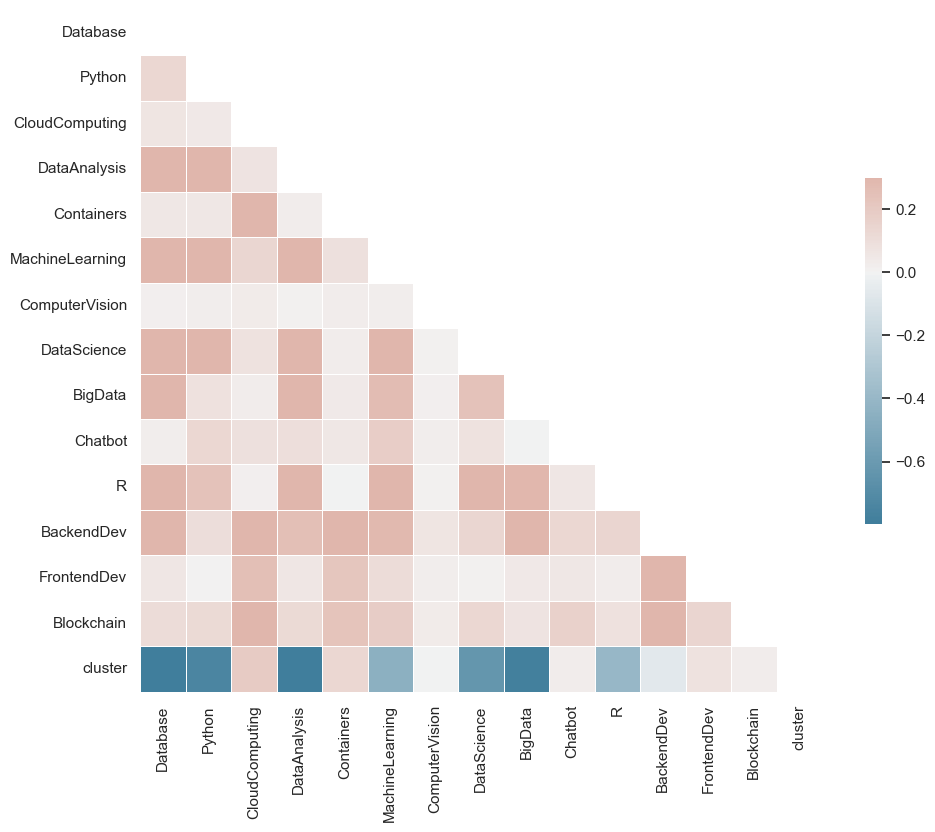

In [19]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = features.cov()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


plt.show()

For example, the feature `MachineLearning` and the feature `DataScience` are correlated. Such covariances among features may indicate that we can apply PCA to find its main components (eigenvectors with max eigenvalues on the covariance matrix). 

If we only keep the independent main components, then we can reduce the dimensions of our user profile feature vectors.


Now let's apply the `PCA()` provided by  `scikit-learn` to find the main components in user profile feature vectors and see if we can reduce its dimensions by only keeping the main components.


Note that when calling the  `PCA()` class, there is also an import argument called `n_components` which indicates how many components you want to keep in the PCA result. One way to find an optimized `n_components` is to do a grid search on a list of argument candidates (such as `range(1, 15)`) and calculate the ratio of the accumulated variance for each candidate. 

If the accumulated variances ratio of a candidate `n_components` is larger than a threshold, e.g., 90%, then we can say the transformed `n_components` could explain about 90% of variances of the original data variance and can be considered as an optimized components size.


_TODO: Find the optimized `n_components` for PCA_


In [20]:
# WRITE YOUR CODE HERE

# - For a list of candidate `n_components` arguments such as 1 to 14, find out the minimal `n` that can explain accumulated 90% variances of previous data
# - In the fitted PCA() model, you can find explained_variance_ratio_ and use the sum() function to add them to get the accumulated variance ratio

from sklearn.decomposition import PCA

# Initialize an empty list to store accumulated variance ratios
accumulated_variance_ratios = []

# Define a range of candidate values for n_components
candidate_components = range(1, 15)

# Iterate over each candidate value of n_components
for n_components in candidate_components:
    # Initialize PCA with the current value of n_components
    pca = PCA(n_components=n_components)
    # Fit PCA to the features and transform them
    transformed_features = pca.fit_transform(features)
    # Calculate the accumulated variance ratio
    accumulated_variance_ratio = np.sum(pca.explained_variance_ratio_)
    # Append the accumulated variance ratio to the list
    accumulated_variance_ratios.append(accumulated_variance_ratio)

# Find the smallest n_components value for which accumulated variance ratio >= 0.9
optimal_n_components = next(n for n, ratio in zip(candidate_components, accumulated_variance_ratios) if ratio >= 0.9)

print("Optimized n_components:", optimal_n_components)

Optimized n_components: 9


<details>
    <summary>Click here for Hints</summary>
    
* For each `n_components` from 1 to 14 you can call `PCA=PCA(n_components=component)`, then you can simply fit it by callsing `pca.fit_transform(features)` where `features = user_profile_df.loc[:, user_profile_df.columns != 'user']`. 
* Then you can find `accumulated_variance_ratios` by applying `sum()` to `pca.explained_variance_ratio_`. 
* Then find the smallest n_components value for which `accumulated_variance_ratios >= 0.9` and return it.
</details>


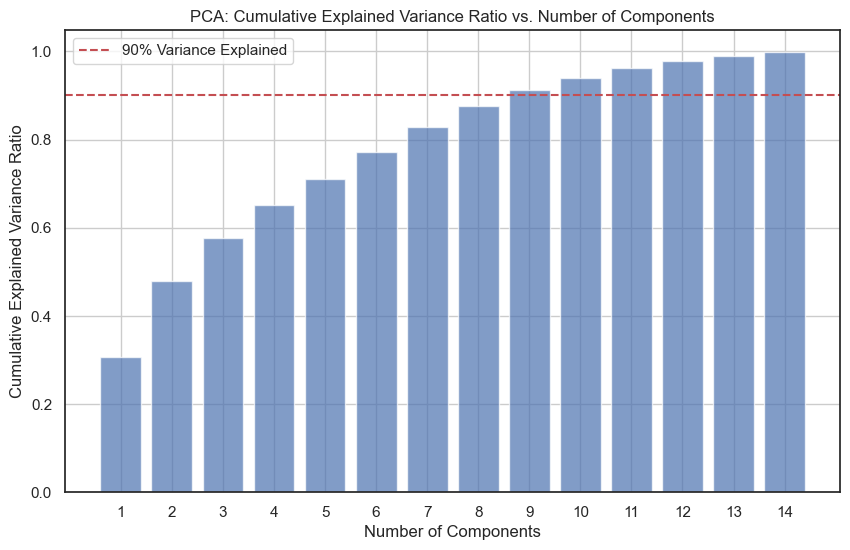

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(candidate_components, accumulated_variance_ratios, color='b', alpha=0.7)
plt.title('PCA: Cumulative Explained Variance Ratio vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Explained')
plt.legend()
plt.grid(True)
plt.xticks(candidate_components)
plt.show()

If you visualize your hyperparameter searching process, you may get a trend line like the following:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_3/images/pca.png)


Once you found the optimized `n_component` argument value, you can apply PCA on the user profile feature vectors and reduce the  14 features into  `n_component` features.


_TODO: Perform PCA to transform original user profile features_


In [22]:
# WRITE YOUR CODE HERE

# - For a list of candidate `n_components` arguments such as 1 to 14, find out the minimal `n` that can explain accumulated 90% variances of previous data
# - In the fitted PCA() model, you can find explained_variance_ratio_ and use the sum() function to add them to get the accumulated variance ratio
# - Merge the user ids and transformed features into a new dataframe

from sklearn.decomposition import PCA

# Initialize PCA with the optimized number of components
pca = PCA(n_components=optimal_n_components)

# Fit PCA to the features and transform them
transformed_features = pca.fit_transform(features)

# Create a DataFrame for the transformed features
transformed_features_df = pd.DataFrame(data=transformed_features)

# Merge the user IDs with the transformed features
pca_user_profile_df = pd.merge(user_ids, transformed_features_df, left_index=True, right_index=True)

# Rename the columns of the transformed features
pca_user_profile_df.columns = ['user'] + [f'component_{i+1}' for i in range(optimal_n_components)]

# Display the PCA transformed dataframe
print(pca_user_profile_df)

          user  component_1  component_2  component_3  component_4  \
0            2   -14.344879     8.133604    -0.784776     7.785915   
1            4    -6.504012     0.711592     0.665847     4.499312   
2            5    -8.702599     6.863756    -2.738141     4.123398   
3            7     2.345235    -0.480169     0.349354     0.792661   
4            8     1.633107    -0.467742     0.608992     1.551347   
...        ...          ...          ...          ...          ...   
33896  2102054    -1.152217     0.009959    -0.268323    -0.139300   
33897  2102356     2.650329    -0.238296     0.167018     0.437950   
33898  2102680    -1.260657    -0.497273    -1.579858    -0.708500   
33899  2102983     2.554136    -0.437241     0.009475     0.617616   
33900  2103039     2.554136    -0.437241     0.009475     0.617616   

       component_5  component_6  component_7  component_8  component_9  
0         0.779409     3.501988    -2.939476    -0.254329    -0.239972  
1        -1.1

<details>
    <summary>Click here for Hints</summary>
    
* Call PCA class as `pca = PCA(n_components=n_components)` 
* Fit PCA model using predefined `features` variable as only parameter
* Get the components by calling `pca.fit_transform(features)` 
* Create a `pd.DataFrame(data=components)` and use `pd.merge` to merge it with `user_ids` don't forget to specify `left_index=True, right_index=True` in `merge` function parameters.
    
</details> 
    


Your PCA transformed dataframe may look like the following:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_3/images/pca_res.png)


### TASK: Perform k-means clustering on the PCA transformed feature vectors


Now, you have the PCA  components of the original profile vectors. You can perform k-means on them again:


_TODO: Perform K-means on the PCA transformed features_


In [23]:
## WRITE YOUR CODE HERE

## - Apply KMeans() on the PCA features
## - Obtain the cluster label lists from model.labels_ attribute
## - Assign each user a cluster label by combining user ids and cluster labels

from sklearn.cluster import KMeans

# Define the number of clusters
n_clusters = 5  # or any other desired number of clusters

# Apply KMeans on the PCA transformed features
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=rs)
kmeans_pca.fit(transformed_features)

# Obtain the cluster labels
pca_cluster_labels = kmeans_pca.labels_

# Combine user IDs and cluster labels
pca_cluster_df = combine_cluster_labels(user_ids, pca_cluster_labels)

# Display the resulting dataframe
print(pca_cluster_df)

          user  cluster
0            2        2
1            4        0
2            5        2
3            7        1
4            8        1
...        ...      ...
33896  2102054        3
33897  2102356        1
33898  2102680        3
33899  2102983        1
33900  2103039        1

[33901 rows x 2 columns]


Your clustering results should have the same format as the k-means on the original dataset:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_3/images/cluster_labels.png)


Great, now all users find their learning interest groups, either based on their original or the PCA transformed user profile features. 


When a user is in a group or a community, it is very likely that the user will be interested in the courses enrolled by other members within the same group.


### TASK: Generate course recommendations based on the popular courses in the same cluster


The Intuition of clustering-based course recommendation is very simple and can be illustrated via the following example:


Suppose a user has joined a machine learning group (via clustering algorithm). In the group, he/she finds that the top-3 courses enrolled by all other group members are `Machine Learning for Everyone`, `Machine Learning with Python`, `Machine Learning with Scikit-learn`. Since the user has already completed the `Machine Learning for Everyone` earlier, he/she decides to trust the group members' choices and enroll in other two unselected courses `Machine Learning with Python` and `Machine Learning with Scikit-learn`.


In summary, the clustering-based recommender system first groups all users based on their profiles, and maintains a popular courses list for each group. 

For any group member who needs course recommendations, the algorithm recommends the unselected courses from the popular course lists.


Next, suppose we have a set of test users, and we want to recommend new courses to them using a clustering-based recommender system:


In [24]:
test_user_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-ML0321EN-Coursera/labs/v2/module_3/ratings.csv"

# Reading the test user data CSV file into a pandas DataFrame
# Selecting only the 'user' and 'item' columns using indexing
test_users_df = pd.read_csv(test_user_url)[['user', 'item']]

# Displaying the first few rows of the DataFrame to inspect its contents
test_users_df.head()

,user,item
0,1889878,CC0101EN
1,1342067,CL0101EN
2,1990814,ML0120ENv3
3,380098,BD0211EN
4,779563,DS0101EN


The test users dataset has only two columns, the user id and the enrolled course id. 


For each user, let's find its cluster label using the k-means results you have performed in previous steps, assuming it is named `cluster_df`.


You can assign the cluster label to all test users via merging the clustering labels (`cluster_df`:):


In [25]:
test_users_labelled = pd.merge(test_users_df, cluster_df, left_on='user', right_on='user')
test_users_labelled

,user,item,cluster
0,1889878,CC0101EN,2
1,1342067,CL0101EN,0
2,1990814,ML0120ENv3,2
3,380098,BD0211EN,2
4,779563,DS0101EN,1
...,...,...,...
233301,1540125,DS0101EN,0
233302,1250651,PY0101EN,4
233303,1003832,CB0105ENv1,3
233304,922065,BD0141EN,0


The merged the test dataset may look like the following:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_3/images/test_users_label.png)


From the above dataframe, we know each user's enrolled courses and its cluster index.


If we use a `groupby`  and `sum` aggregation, we can get the enrollments count for each course in each group, like the following code snippet:


In [26]:
# Extracting the 'item' and 'cluster' columns from the test_users_labelled DataFrame
courses_cluster = test_users_labelled[['item', 'cluster']]

# Adding a new column 'count' with a value of 1 for each row in the courses_cluster DataFrame
courses_cluster['count'] = [1] * len(courses_cluster)

# Grouping the DataFrame by 'cluster' and 'item', aggregating the 'count' column with the sum function,
# and resetting the index to make the result more readable
courses_cluster_grouped = courses_cluster.groupby(['cluster','item']).agg(enrollments=('count','sum')).reset_index()

_TODO: For each test user, try to recommend any unseen courses based on the popular courses in his/her cluster. You may use an enrollment count threshold (such as larger than 10) to determine if it is a popular course in the cluster_ 


In [27]:
def generate_course_recommendations(test_users_labelled, courses_cluster_grouped, enrollment_threshold=10):
    # Initialize an empty dictionary to store recommendations for each user
    recommendations = {}

    # Iterate through each test user
    for user_id in test_users_labelled['user'].unique():
        # Filter the DataFrame to get information about the current user
        user_subset = test_users_labelled[test_users_labelled['user'] == user_id]
        
        # Get the enrolled courses of the current user
        enrolled_courses = set(user_subset['item'])
        
        # Get the cluster label of the current user (assuming all entries have the same cluster label for a user)
        cluster_id = user_subset['cluster'].iloc[0]
        
        # Get all courses belonging to the same cluster as the current user
        cluster_courses = set(courses_cluster_grouped[courses_cluster_grouped['cluster'] == cluster_id]['item'])
        
        # Find new/unseen courses to the user by taking a set difference
        unseen_courses = cluster_courses.difference(enrolled_courses)
        
        # Filter popular courses among unseen courses based on enrollment threshold
        popular_unseen_courses = set(courses_cluster_grouped[
            (courses_cluster_grouped['cluster'] == cluster_id) & 
            (courses_cluster_grouped['item'].isin(unseen_courses)) & 
            (courses_cluster_grouped['enrollments'] >= enrollment_threshold)
        ]['item'])
        recommendations[user_id] = popular_unseen_courses
    
    return recommendations
recommendations = generate_course_recommendations(test_users_labelled, courses_cluster_grouped)

<details>
    <summary>Click here for Hints</summary>
    
* First of all, create a `user_subset` of  `test_users_labelled` where `test_users_labelled['user'] == user_id`. 
* Get the enrolled courses by  simply accessing `['item']` column of `user_subset`
* Find its cluster label by accessing `['cluster']` column of `user_subset`. You can just use the first one (`.iloc[0]`) since every value in the column is the same for an individual user.
* You can find all courses in the same cluster, by simply accessing `['item']` column of a subset of `test_users_labelled` where `test_users_labelled[test_users_labelled['cluster'] == cluster_id]`
* You can find new/unseen courses to the user by taking a set difference between courses in cluster and enrolled_courses by using `.difference` method (dont forget to convert 2 lists in to sets before calling the method). 
* Use `courses_cluster` data set to find popularity of new/unseen courses and make unseen and popular courses as recommendation results for the user
    
</details> 


In [28]:
from collections import Counter

# Calculate the average number of new/unseen courses recommended to each user
total_users = len(recommendations)
total_recommendations = sum(len(rec_courses) for rec_courses in recommendations.values())
average_recommendations_per_user = total_recommendations / total_users

print("Average recommended courses per user:", average_recommendations_per_user)

# Identify the top-10 most frequently recommended courses across all users
all_recommendations = [rec_course for rec_courses in recommendations.values() for rec_course in rec_courses]
recommended_courses_count = Counter(all_recommendations)
top_10_recommendations = recommended_courses_count.most_common(10)

print("Top-10 most frequently recommended courses:")
for course, count in top_10_recommendations:
    print(f"Course: {course}, Recommended {count} times")

Average recommended courses per user: 87.6848765523141
Top-10 most frequently recommended courses:
Course: CB0101EN, Recommended 33678 times
Course: ML0120ENv3, Recommended 33596 times
Course: DJ0101EN, Recommended 33538 times
Course: BD0153EN, Recommended 33515 times
Course: DS0201EN, Recommended 33495 times
Course: EE0101EN, Recommended 33477 times
Course: IT0101EN, Recommended 33443 times
Course: ML0111EN, Recommended 33438 times
Course: DE0205EN, Recommended 33416 times
Course: CC0250EN, Recommended 33403 times


With the recommendation results, you also need to write some analytic code to answer the following two questions:


- On average, how many new/unseen courses have been recommended to each user?
- What are the most frequently recommended courses? Return the top-10 commonly recommended courses across all users.


For example, suppose we have only 3 test users, each user receives the following recommendations:


- User1: ['course1', 'course2']
- User2: ['course3', 'course4']
- User3: ['course3', 'course4', 'course5']


Then, the average recommended courses per user is $(2 + 2 + 3) / 3 = 2.33$. The top-2 recommended courses are: `course3`: 2 times, and `course4`: 2 times.


Note that the answers will depend on how you compute the popular courses for each cluster. A lower threshold yields more recommended courses but with smaller confidence so that some test users may receive very long course recommendation lists and feel overwhelmed. 

Ideally, we should limit the maximum course recommendations for each user to be less than 20 courses per user.


### Explore other clustering algorithms


As you have learned in previous unsupervised learning course, there are many other clustering algorithms such as `DBSCAN` and `Hierarchical Clustering`. You are encouraged to try them on the user profile feature vectors and compare the results with K-means.


### Summary


Congratulations! In this lab, you have applied clustering algorithms to group users with similar interests and also tried PCA to reduce the dimensions of user feature vectors.

Furthermore, with each user finding its learning interest group, you have also implemented clustering-based course recommender system to make recommendations based on his/her group members' popular courses choices.


## Authors


[Yan Luo]((https://www.linkedin.com/in/yan-luo-96288783/)


### Other Contributors


```toggle## Change Log
```


```toggle|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
```
```toggle|-|-|-|-|
```
```toggle|2021-10-25|1.0|Yan|Created the initial version|
```


Copyright © 2021 IBM Corporation. All rights reserved.
